<a href="https://colab.research.google.com/github/adalahardana/hasil-kuliah/blob/main/noice_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT LIBRARY

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
from google.colab import files

#set warning
import warnings
warnings.filterwarnings('ignore')


pd.pandas.set_option('display.max_columns', None)

In [2]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]
print(f"✅ File '{filename}' berhasil diupload!")

Saving noice_rawdata.csv to noice_rawdata.csv
✅ File 'noice_rawdata.csv' berhasil diupload!


In [3]:
df = pd.read_csv(filename, encoding='utf-8')  # ubah ke 'latin-1' kalau error karakter
df.head()

,review_id,user_name,user_review,rating,review_date,app_version,review_created_version
0,f913e55b-47fa-4e6b-8613-2ef398feb761,Naf'an Chaerul,Crash terus. Ngga bisa didengerin sambil buka ...,3,3/31/2024,3.22,3.22
1,5277670b-45a3-484b-99e2-3d1fc962c913,agus waluyo,maantaaap bagus bangeeet...,5,3/31/2024,3.34,3.34
2,71d9417f-de64-42ce-9241-77e1f289f347,Rajuddin Siregar,bagoss,5,3/31/2024,3.36,3.36
3,bf6ce888-da4b-46c4-9452-8ef9119e9172,Maikel Rivaldo,Kok loading nya lama yaa sampe Berjam jam di t...,2,3/31/2024,3.34,3.34
4,b0c9a488-36cc-459b-9912-47c2d5b87977,Dimas S Yudistira,"Sering tiba2 mati sendiri, diputar lagi ngulan...",1,3/30/2024,3.34,3.34


In [4]:
df.drop(columns = ['review_id', 'user_name', 'review_date', 'app_version', 'review_created_version'], inplace = True)
df.columns = ['user_review', 'rating']
df.head()

,user_review,rating
0,Crash terus. Ngga bisa didengerin sambil buka ...,3
1,maantaaap bagus bangeeet...,5
2,bagoss,5
3,Kok loading nya lama yaa sampe Berjam jam di t...,2
4,"Sering tiba2 mati sendiri, diputar lagi ngulan...",1


PREPROCESSING DATA

Cleaning Data

In [5]:
import string
import re

In [6]:
def clean_text(text):
    return re.sub('[^a-zA-Z]', ' ', text).lower()
df['cleaned_text'] = df['user_review'].apply(lambda x: clean_text(x))
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['label'] = df['rating'].map({1: 0, 2: 0, 3: 0, 4: 1, 5: 1})

Adding additional features - length of, and percentage of punctuations in the text

In [7]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100
df['review_len'] = df['user_review'].apply(lambda x: len(x) - x.count(" "))
df['punct'] = df['user_review'].apply(lambda x: count_punct(x))
df.head()

,user_review,rating,cleaned_text,label,review_len,punct
0,Crash terus. Ngga bisa didengerin sambil buka ...,3.0,crash terus ngga bisa didengerin sambil buka ...,0.0,103,4.9
1,maantaaap bagus bangeeet...,5.0,maantaaap bagus bangeeet,1.0,25,12.0
2,bagoss,5.0,bagoss,1.0,6,0.0
3,Kok loading nya lama yaa sampe Berjam jam di t...,2.0,kok loading nya lama yaa sampe berjam jam di t...,0.0,73,1.4
4,"Sering tiba2 mati sendiri, diputar lagi ngulan...",1.0,sering tiba mati sendiri diputar lagi ngulan...,0.0,53,1.9


Tokenization

In [12]:
def tokenize_text(text):
    tokenized_text = text.split()
    return tokenized_text
df['tokens'] = df['cleaned_text'].apply(lambda x: tokenize_text(x))
df.head()

,user_review,rating,cleaned_text,label,review_len,punct,tokens
0,Crash terus. Ngga bisa didengerin sambil buka ...,3.0,crash terus ngga bisa didengerin sambil buka ...,0.0,103,4.9,"[crash, terus, ngga, bisa, didengerin, sambil,..."
1,maantaaap bagus bangeeet...,5.0,maantaaap bagus bangeeet,1.0,25,12.0,"[maantaaap, bagus, bangeeet]"
2,bagoss,5.0,bagoss,1.0,6,0.0,[bagoss]
3,Kok loading nya lama yaa sampe Berjam jam di t...,2.0,kok loading nya lama yaa sampe berjam jam di t...,0.0,73,1.4,"[kok, loading, nya, lama, yaa, sampe, berjam, ..."
4,"Sering tiba2 mati sendiri, diputar lagi ngulan...",1.0,sering tiba mati sendiri diputar lagi ngulan...,0.0,53,1.9,"[sering, tiba, mati, sendiri, diputar, lagi, n..."


Lemmatization and Removing Stopwords

In [13]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('indonesian')


if 'tidak' in stop_words:
    stop_words.remove('tidak')

print(f"Total stopwords Indonesia: {len(stop_words)}")


Total stopwords Indonesia: 757


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def lemmatize_text_indo(tokens):
    filtered = [word for word in tokens if word not in stop_words]
    stemmed = [stemmer.stem(word) for word in filtered]
    return " ".join(stemmed)

df['lemmatized_review'] = df['tokens'].apply(lemmatize_text_indo)
df[['user_review', 'lemmatized_review']].head()


,user_review,lemmatized_review
0,Crash terus. Ngga bisa didengerin sambil buka ...,crash ngga didengerin buka aplikasi ngga smoot...
1,maantaaap bagus bangeeet...,maantaaap bagus bangeeet
2,bagoss,bagoss
3,Kok loading nya lama yaa sampe Berjam jam di t...,loading nya yaa sampe jam jam tunggu nga jarin...
4,"Sering tiba2 mati sendiri, diputar lagi ngulan...",mati putar ngulang


EDA

Dataset memiliki 2157 baris dan 6 kolom

Rating 1 = 440 baris
Rating 2 = 123 baris
Rating 3 = 171 baris
Rating 4 = 201 baris
Rating 5 = 1221 baris

--- Missing Values ---
Jumlah nilai kosong di kolom rating: 1
Jumlah nilai kosong di kolom user_review: 0


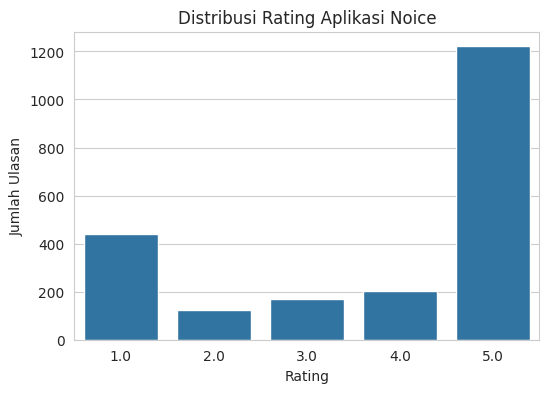

In [8]:


print(f"Dataset memiliki {len(df)} baris dan {len(df.columns)} kolom\n")


for i in range(1, 6):
    print(f"Rating {i} = {len(df[df['rating'] == i])} baris")


print("\n--- Missing Values ---")
print(f"Jumlah nilai kosong di kolom rating: {df['rating'].isnull().sum()}")
print(f"Jumlah nilai kosong di kolom user_review: {df['user_review'].isnull().sum()}")


plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=df)
plt.title('Distribusi Rating Aplikasi Noice')
plt.xlabel('Rating')
plt.ylabel('Jumlah Ulasan')
plt.show()


Visualizing Word Clouds

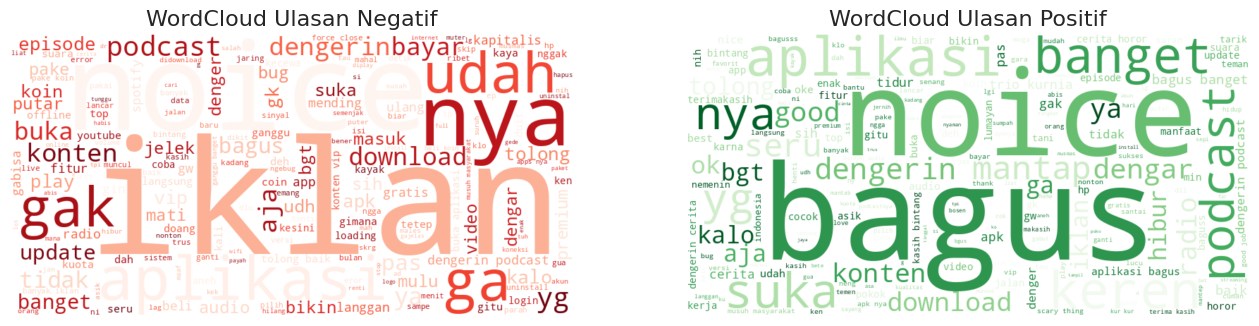

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Pisahkan data berdasarkan rating
df_negative = df[(df['rating'] == 1.0) | (df['rating'] == 2.0) | (df['rating'] == 3.0)]
df_positive = df[(df['rating'] == 4.0) | (df['rating'] == 5.0)]

# Konversi ke list
negative_list = df_negative['lemmatized_review'].dropna().tolist()
positive_list = df_positive['lemmatized_review'].dropna().tolist()

# Gabungkan jadi satu string besar
filtered_negative = " ".join(negative_list).lower()
filtered_positive = " ".join(positive_list).lower()

# Buat WordCloud untuk ulasan negatif
wordcloud_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(filtered_negative)

# Buat WordCloud untuk ulasan positif
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(filtered_positive)

# Tampilkan hasil
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Ulasan Negatif', fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Ulasan Positif', fontsize=16)

plt.show()


Visualize Confusion Matrix

Vectorizer : TF-IDF

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

df = df.dropna(subset=['lemmatized_review', 'label'])
df = df[df['lemmatized_review'].str.strip() != '']


# Pisahkan data
X = df['lemmatized_review']
y = df['label']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)


Algoritma : Multinomial Naive Bayes

              precision    recall  f1-score   support

         0.0       0.78      0.69      0.73       135
         1.0       0.86      0.91      0.88       288

    accuracy                           0.84       423
   macro avg       0.82      0.80      0.81       423
weighted avg       0.83      0.84      0.83       423



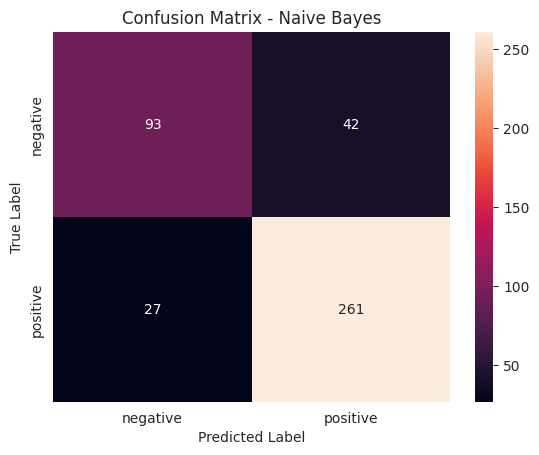

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix


classifier = MultinomialNB()
classifier.fit(X_train_vect, y_train)
naive_bayes_pred = classifier.predict(X_test_vect)

# Classification Report
print(classification_report(y_test, naive_bayes_pred))

# Confusion Matrix
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, naive_bayes_pred), index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Algoritma: Random Forest Classifier


📊 Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.84      0.71       135
         1.0       0.91      0.75      0.82       288

    accuracy                           0.78       423
   macro avg       0.76      0.80      0.77       423
weighted avg       0.81      0.78      0.79       423



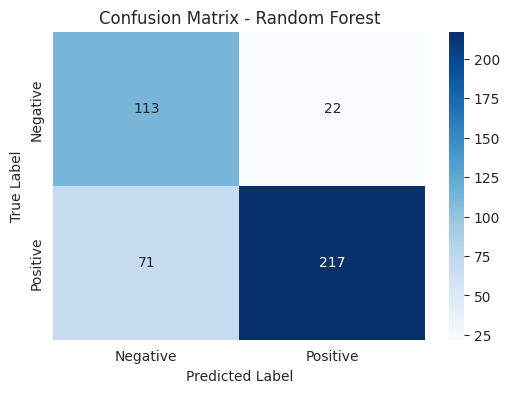

In [25]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=150, random_state=42)
classifier.fit(X_train_vect, y_train)


random_forest_pred = classifier.predict(X_test_vect)


print("\n📊 Classification Report:")
print(classification_report(y_test, random_forest_pred))


class_label = ["Negative", "Positive"]
df_cm = pd.DataFrame(
    confusion_matrix(y_test, random_forest_pred),
    index=class_label,
    columns=class_label
)

plt.figure(figsize=(6,4))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Algoritma: Support Vector Machine (SVM)


📊 Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.79      0.77       135
         1.0       0.90      0.88      0.89       288

    accuracy                           0.85       423
   macro avg       0.82      0.83      0.83       423
weighted avg       0.85      0.85      0.85       423



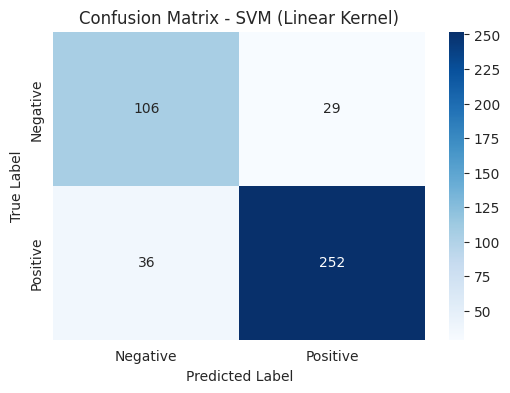

In [26]:
from sklearn.svm import SVC
classifier = SVC(kernel='linear', random_state=0)
classifier.fit(X_train_vect, y_train)


svm_pred = classifier.predict(X_test_vect)


print("\n📊 Classification Report:")
print(classification_report(y_test, svm_pred))


class_label = ["Negative", "Positive"]
df_cm = pd.DataFrame(
    confusion_matrix(y_test, svm_pred),
    index=class_label,
    columns=class_label
)

plt.figure(figsize=(6,4))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix - SVM (Linear Kernel)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Algoritma: K-Nearest Neighbor (KNN)


📊 Classification Report:
              precision    recall  f1-score   support

         0.0       0.45      0.93      0.61       135
         1.0       0.93      0.47      0.63       288

    accuracy                           0.62       423
   macro avg       0.69      0.70      0.62       423
weighted avg       0.78      0.62      0.62       423



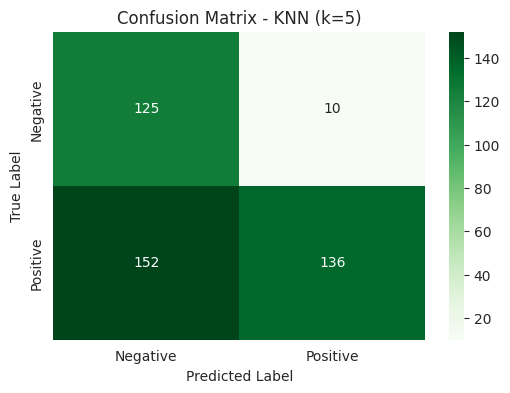

In [27]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train_vect, y_train)


knn_pred = classifier.predict(X_test_vect)


print("\n📊 Classification Report:")
print(classification_report(y_test, knn_pred))


class_label = ["Negative", "Positive"]
df_cm = pd.DataFrame(
    confusion_matrix(y_test, knn_pred),
    index=class_label,
    columns=class_label
)

plt.figure(figsize=(6,4))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Greens")
plt.title("Confusion Matrix - KNN (k=5)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Performing K-Fold Cross Validation

In [28]:
from sklearn.model_selection import cross_val_score

models = [
          MultinomialNB(),
          RandomForestClassifier(n_estimators = 150),
          SVC(kernel = 'linear'),
          KNeighborsClassifier(n_neighbors = 5),
         ]
names = ["Naive Bayes", "Random Forest", "SVM", "KNN"]
for model, name in zip(models, names):
    print(name)
    for score in ["accuracy", "precision", "recall", "f1"]:
        print(f" {score} - {cross_val_score(model, X_train_vect, y_train, scoring=score, cv=10).mean()} ")
    print()

Naive Bayes
 accuracy - 0.8515593456317438 
 precision - 0.8609629191502725 
 recall - 0.9207339449541285 
 f1 - 0.8895240702500985 

Random Forest
 accuracy - 0.7752697528715629 
 precision - 0.8988043026905549 
 recall - 0.740208507089241 
 f1 - 0.8141756173164205 

SVM
 accuracy - 0.8527358162199791 
 precision - 0.864558309804383 
 recall - 0.9170809007506258 
 f1 - 0.8898610877268969 

KNN
 accuracy - 0.649366515837104 
 precision - 0.9523557161898895 
 recall - 0.485929941618015 
 f1 - 0.6327558596322337 



PREDICTIONS



*   Vectorizer : CountVectorizer (Bag of words)
*   Algoritma : Multinomial Naive Bayes




In [32]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000)  # batas 5000 fitur biar efisien
X_cv = cv.fit_transform(df['lemmatized_review'])
y_cv = df['label']

from sklearn.model_selection import train_test_split
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(
    X_cv, y_cv, test_size=0.3, random_state=42
)




In [33]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

clf.fit(X_train_cv, y_train_cv)
clf.score(X_test_cv, y_test_cv)

0.8346456692913385

In [34]:
data = ["Ga", "Bagus", "Banyak iklan, jelek", "Bisa ditingkatkan lagi"]
vect = cv.transform(data).toarray()

my_prediction = clf.predict(vect)
print(my_prediction)

[0. 1. 0. 1.]
